<a href="https://colab.research.google.com/github/colingwuyu/HedgingBox/blob/develop/qtable_bot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install necessary dependencies.
!pip install dm-acme
!pip install dm-acme[reverb]
!pip install dm-acme[tf]
!pip install dm-acme[envs]


In [1]:
#@title Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#@title Update HedgingBox
import os
project_folder = '/content/gdrive/My Drive/Projects'
hb_source = os.path.join(project_folder, 'HedgingBox')
%mkdir "$project_folder"
%cd "$project_folder"
!pwd
!mkdir -p '../ACME Models/QTable'
!git clone https://github.com/colingwuyu/HedgingBox.git
%cd HedgingBox
!git fetch --all
!git checkout -b develop origin/develop 
!git pull
import sys
sys.path.append(hb_source)

In [3]:
#@title Import Modules
import acme
import dm_env
from acme import specs
from acme import datasets
from acme import wrappers
from acme.adders import reverb as adders

import reverb

import numpy as np
import matplotlib.pyplot as plt

import hb
from hb.market_env import hedging_market_env
from hb.market_env.pathgenerators import gbm_pathgenerator
from hb.market_env.rewardrules.pnl_reward import PnLReward
from hb.market_env.rewardrules.pnl_sqrpenalty_reward import PnLSquarePenaltyReward
from hb.market_env import market_specs
from hb.bots.qtablebot.bot import QTableBot
from hb.bots.qtablebot.actor import QTableActor
from hb.bots.qtablebot.learning import QTableLearner
from hb.bots.qtablebot.qtable import QTable
from hb.bots.deltabot.bot import DeltaHedgeBot

Build Environment

In [34]:
#@title Default title text
trading_cost_pct = 0.2 #@param {type:"number"}
gbm = gbm_pathgenerator.GBMGenerator(
            initial_price=50., drift=0.05,
            div=0.0, sigma=0.15, num_step=3, step_size=30./365.,
        )
pnl_penalty_reward = PnLSquarePenaltyReward(scale_k=1e-3)
pnl_reward = PnLReward()
market_param = market_specs.MarketEnvParam(
    stock_ticker_size=1.,
    stock_price_lower_bound=45.,
    stock_price_upper_bound=55.,
    lot_size=1,
    buy_sell_lots_bound=4,
    holding_lots_bound=17)
environment = wrappers.SinglePrecisionWrapper(hedging_market_env.HedgingMarketEnv(
            stock_generator=gbm,
            reward_rule=pnl_penalty_reward,
            market_param=market_param,
            trading_cost_pct=trading_cost_pct,
            risk_free_rate=0.,
            discount_rate=0.,
            option_maturity=455./365.,
            option_strike=50.,
            option_holding=-10,
            initial_stock_holding=5,
        ))


In [35]:
#@title Create QTable Hedging Bot
#@markdown ##Replay Buffer Param
batch_size =  1#@param {type:"integer"}
samples_per_insert =  1#@param {type:"integer"}
min_replay_size =  1#@param {type:"integer"}
qtable_bot_env_attr = ['remaining_time', 'stock_holding', 'stock_price']
environment.set_obs_attr(qtable_bot_env_attr)
spec = specs.make_environment_spec(environment)
qtable_bot = QTableBot(environment_spec=spec,
                       epsilon=0.8,
                       batch_size=batch_size,
                       samples_per_insert=samples_per_insert, 
                       min_replay_size=min_replay_size)

In [38]:
#@title Train QTable
environment.set_obs_attr(qtable_bot_env_attr)
num_episodes = 30000 #@param {type:"integer"}
epsilon = 0.2 #@param {type:"number"}
model_name = "20pcttradingcost" #@param {type:"string"}
model_location = f'../ACME Models/QTable/{model_name}_qtable.pickle'
if os.path.exists(model_location):
  qtable_bot.restore(model_location)
qtable_bot._actor._epsilon = epsilon
# Try running the environment loop. We have no assertions here because all
# we care about is that the agent runs without raising any errors.
loop = acme.EnvironmentLoop(environment, qtable_bot)
loop.run(num_episodes=num_episodes)
# save model
qtable_bot.save(model_location)

[Learner] Avg Td Error = 0.563 | Steps = 180001 | Walltime = 505.626
[Environment Loop] Episode Length = 3 | Episode Return = -69.046 | Episodes = 120 | Steps = 360 | Steps Per Second = 335.187
[Learner] Avg Td Error = -28.555 | Steps = 180361 | Walltime = 506.629
[Environment Loop] Episode Length = 3 | Episode Return = 43.621 | Episodes = 248 | Steps = 744 | Steps Per Second = 395.093
[Learner] Avg Td Error = 0.705 | Steps = 180745 | Walltime = 507.632
[Environment Loop] Episode Length = 3 | Episode Return = 7.600 | Episodes = 376 | Steps = 1128 | Steps Per Second = 392.517
[Learner] Avg Td Error = 1.116 | Steps = 181129 | Walltime = 508.636
[Environment Loop] Episode Length = 3 | Episode Return = -1.900 | Episodes = 505 | Steps = 1515 | Steps Per Second = 408.284
[Learner] Avg Td Error = -1.132 | Steps = 181516 | Walltime = 509.641
[Environment Loop] Episode Length = 3 | Episode Return = 3.310 | Episodes = 634 | Steps = 1902 | Steps Per Second = 396.537
[Learner] Avg Td Error = 1.007

(array([ 11., 145., 298., 254., 156.,  82.,  33.,  16.,   3.,   2.]),
 array([-44.83219174, -30.01535642, -15.19852109,  -0.38168577,
         14.43514956,  29.25198489,  44.06882021,  58.88565554,
         73.70249086,  88.51932619, 103.33616152]),
 <a list of 10 Patch objects>)

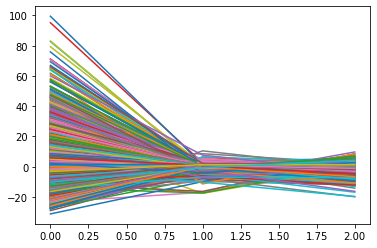

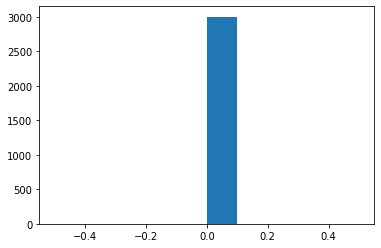

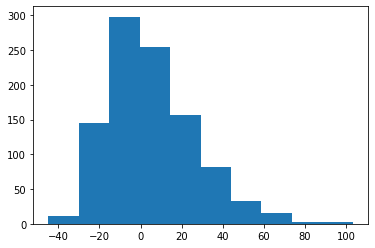

In [39]:
#@title Predict by QTable Hedging Bot
pred_num_episodes = 1000 #@param {type:"integer"}
actor = QTableActor(qtable_bot.get_qtable(), epsilon=0.)
qtable_action_list = np.array([])
qtable_pnl_list = np.array([])
figure = plt.figure()
for episode in range(pred_num_episodes):
    episode_pnl = 0.
    episode_pnl_path = np.array([])
    episode_action = np.array([])
    timestep = environment.reset()
    pnl_reward.reset(environment._state_values)

    while not timestep.last():
        action = actor.select_action(timestep.observation)
        episode_action = np.append(episode_action, action)
        timestep = environment.step(action)
        pnl = pnl_reward.step_reward(
                dm_env.StepType.MID,
                environment._state_values,
                action)
        episode_pnl += pnl
        episode_pnl_path = np.append(episode_pnl_path, pnl)
    qtable_pnl_list = np.append(qtable_pnl_list, episode_pnl)
    qtable_action_list = np.append(qtable_action_list, episode_action)
    plt.plot(episode_pnl_path)
    # print('PnL Mean: %s' % str(np.mean(pnl)))
    # print('PnL Std:  %s' % str(np.std(pnl)))

figure = plt.figure()
plt.hist(qtable_action_list)

figure = plt.figure()
plt.hist(qtable_pnl_list)

In [40]:
#@title Create Delta Hedging Bot and Set Env State Space
delta_bot_env_attr = ['remaining_time', 'option_holding', 'option_strike',
                      'interest_rate', 'stock_price', 'stock_dividend',
                      'stock_sigma', 'stock_holding']
environment.set_obs_attr(delta_bot_env_attr)
spec = specs.make_environment_spec(environment)
delta_bot = DeltaHedgeBot(environment_spec=spec)

(array([ 14.,  71., 240., 326., 207.,  96.,  31.,  11.,   3.,   1.]),
 array([-81.48599063, -62.06168827, -42.63738592, -23.21308356,
         -3.7887812 ,  15.63552116,  35.05982352,  54.48412588,
         73.90842824,  93.3327306 , 112.75703296]),
 <a list of 10 Patch objects>)

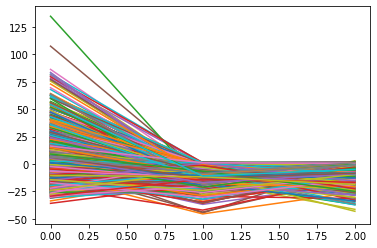

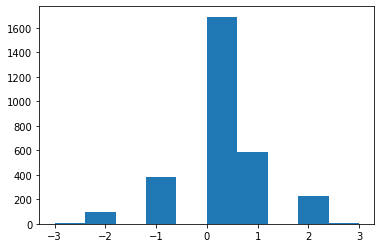

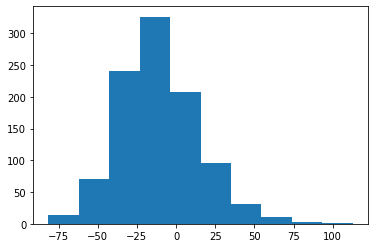

In [41]:
#@title Predict by Delta Hedging Bot
delta_action_list = np.array([])
delta_pnl_list = np.array([])
figure = plt.figure()
for episode in range(pred_num_episodes):
    episode_pnl = 0.
    episode_pnl_path = np.array([])
    episode_action = np.array([])
    timestep = environment.reset()
    pnl_reward.reset(environment._state_values)
    
    while not timestep.last():
        action = delta_bot.select_action(timestep.observation)
        episode_action = np.append(episode_action, action)
        timestep = environment.step(action)
        pnl = pnl_reward.step_reward(
                dm_env.StepType.MID,
                environment._state_values,
                action)
        episode_pnl += pnl
        episode_pnl_path = np.append(episode_pnl_path, pnl)
    delta_pnl_list = np.append(delta_pnl_list, episode_pnl)
    delta_action_list = np.append(delta_action_list, episode_action)
    plt.plot(episode_pnl_path)
    # print('PnL Mean: %s' % str(np.mean(pnl)))
    # print('PnL Std:  %s' % str(np.std(pnl)))

figure = plt.figure()
plt.hist(delta_action_list)

figure = plt.figure()
plt.hist(delta_pnl_list)

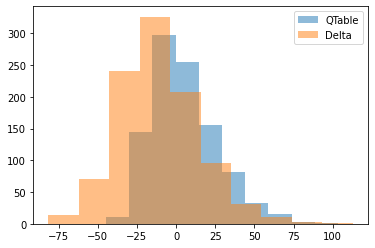

In [42]:
plt.hist(qtable_pnl_list, alpha=0.5, label='QTable')
plt.hist(delta_pnl_list, alpha=0.5, label='Delta')
plt.legend(loc='upper right')
plt.savefig('../ACME Models/QTable/{model_name}_cost.png')
plt.show()

Step by Step Demo of QTable Bot Construction

In [ ]:
#@title Reset Environment
environment.set_obs_attr(qtable_bot_env_attr)
spec = specs.make_environment_spec(environment)

In [ ]:
#@title Build Replay Buffer
replay_table_name = 'replay_table'
replay_table = reverb.Table(
      name=replay_table_name,
      sampler=reverb.selectors.Uniform(),
      remover=reverb.selectors.Fifo(),
      max_size=1,
      rate_limiter=reverb.rate_limiters.MinSize(1),
      signature=adders.NStepTransitionAdder.signature(spec))
server = reverb.Server([replay_table], port=None)
address = f'localhost:{server.port}'
adder = adders.NStepTransitionAdder(
        priority_fns={replay_table_name: lambda x: 1.},
        client=reverb.Client(address),
        n_step=1,
        discount=1.0)
dataset = datasets.make_reverb_dataset(
            table=replay_table_name,
            client=reverb.TFClient(address),
            batch_size=1,
            prefetch_size=None,
            environment_spec=spec,
            transition_adder=True)

dat_iterator = iter(dataset) 

In [ ]:
#@title Create Actor and Learner
step_qtable = QTable(observation_spec=spec.observations, 
                action_spec=spec.actions)
actor = QTableActor(qtable=step_qtable, 
                    epsilon=0.2, 
                    adder=adder)
learner = QTableLearner(qtable=step_qtable, 
                        learning_rate=1e-3, 
                        target_update_period=1, 
                        dataset=dataset)

In [ ]:
#@title Training Loop
num_episodes = 100 #@param {type:"integer"}

actor_steps_taken = 0
learner_steps_taken = 0

for episode in range(num_episodes):
  # actor._adder.reset()
  timestep = environment.reset()
  actor.observe_first(timestep)
  episode_return = 0

  while not timestep.last():
    #learner Get an action from the agent and step in the environment.
    action = actor.select_action(timestep.observation)
    next_timestep = environment.step(action)

    # Record the transition.
    actor.observe(action=action, next_timestep=next_timestep)

    # Book-keeping.
    episode_return += next_timestep.reward
    actor_steps_taken += 1
    learner_steps_taken += 1
    timestep = next_timestep
    learner.step()

  # Log quantities.
  print('Episode: %d | Return: %f | Learner steps: %d | Actor steps: %d'%(
      episode, episode_return, learner_steps_taken, actor_steps_taken))

[Learner] Avg Td Error = -1.914 | Steps = 1 | Walltime = 0
Episode: 0 | Return: -8.049007 | Learner steps: 3 | Actor steps: 3
Episode: 1 | Return: -17.178998 | Learner steps: 6 | Actor steps: 6
Episode: 2 | Return: -1.903435 | Learner steps: 9 | Actor steps: 9
Episode: 3 | Return: -0.645727 | Learner steps: 12 | Actor steps: 12
Episode: 4 | Return: -9.332153 | Learner steps: 15 | Actor steps: 15
Episode: 5 | Return: 2.242455 | Learner steps: 18 | Actor steps: 18
Episode: 6 | Return: -17.981263 | Learner steps: 21 | Actor steps: 21
Episode: 7 | Return: -1.023621 | Learner steps: 24 | Actor steps: 24
Episode: 8 | Return: -7.353714 | Learner steps: 27 | Actor steps: 27
Episode: 9 | Return: -7.473374 | Learner steps: 30 | Actor steps: 30
Episode: 10 | Return: -11.820989 | Learner steps: 33 | Actor steps: 33
Episode: 11 | Return: -3.591912 | Learner steps: 36 | Actor steps: 36
Episode: 12 | Return: -14.469015 | Learner steps: 39 | Actor steps: 39
Episode: 13 | Return: 0.381621 | Learner ste

Dive into Learner step

In [ ]:
#@title First step
actor._adder.reset()
timestep = environment.reset()
actor.observe_first(timestep)
print(timestep.observation)

[455.   0.  50.]


In [ ]:
#@title Mid Actor step
action = actor.select_action(timestep.observation)
next_timestep = environment.step(action)

# Record the transition.
actor.observe(action=action, next_timestep=next_timestep)
print(action)
print(next_timestep.observation)

[2.]
[365.        9.       52.36527]


In [ ]:
#@title Learning Step
learning_rate = 0.001 #@param {type:"number"}
inputs = next(dat_iterator)
o_tm1, a_tm1, r_t, d_t, o_t = inputs.data
avg_td_error = 0.
o_tm1_i = o_tm1[0]
a_tm1_i = a_tm1[0]
r_t_i = r_t[0]
d_t_i = d_t[0]
o_t_i = o_t[0]
cur_q = step_qtable.getQ(o_tm1_i.numpy(), a_tm1_i.numpy())
# bellman eq
target_q = r_t_i + d_t_i * \
    step_qtable.select_maxQ(o_t_i.numpy())
td_error = target_q - cur_q
avg_td_error += td_error
inc = learning_rate * td_error
print(f"action = {a_tm1_i.numpy()[0]}; \nobservation = {o_tm1_i.numpy()}; \ncur_Q = {cur_q}; \ntarget_Q = {target_q}; \ninc = {inc}")
# update qtable
step_qtable.update(o_tm1_i.numpy(), a_tm1_i.numpy(), inc)
avg_td_error = avg_td_error/o_tm1.shape[0]

action = 3.0; 
observation = [455.   0.  50.]; 
cur_Q = 0.2827048897743225; 
target_Q = -1.0892881155014038; 
inc = -0.0013719931012019515
